In [1]:
arr_ru = ['а', 'б', 'в', 'г', 'д', 'е', 'ё', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 
          'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ь', 'ы', 'ъ', 'э', 'ю', 'я']
codes = dict(zip(arr_ru, range(len(arr_ru))))

print(codes)

{'а': 0, 'б': 1, 'в': 2, 'г': 3, 'д': 4, 'е': 5, 'ё': 6, 'ж': 7, 'з': 8, 'и': 9, 'й': 10, 'к': 11, 'л': 12, 'м': 13, 'н': 14, 'о': 15, 'п': 16, 'р': 17, 'с': 18, 'т': 19, 'у': 20, 'ф': 21, 'х': 22, 'ц': 23, 'ч': 24, 'ш': 25, 'щ': 26, 'ь': 27, 'ы': 28, 'ъ': 29, 'э': 30, 'ю': 31, 'я': 32}


In [2]:
from string import punctuation

def encode(s):
    s = s.lower()
    s = ''.join([c for c in s if c not in punctuation])
    
    str_code = [0] * len(s)
    for i in range(len(s)):
        str_code[i] = codes[s[i]]
    
    return str_code

In [3]:
print(encode('аббаа'))

[0, 1, 1, 0, 0]


Загрузим данные, закодируем слова каждой пары:

In [5]:
import pandas as pd

data = pd.read_csv('final_balanced_cognates_dataset.csv', encoding='cp1251')

In [6]:
data['first_code'] = data.apply(lambda row: encode(row.first_word), axis=1)
data['second_code'] = data.apply(lambda row: encode(row.second_word), axis=1)
data.head()

,Unnamed: 0,first_word,second_word,Levenshtein,longest_common_substr,longest_common_subs,class,Levenshtein_stemmed,LCS_stemmed,Levenshtein_similarity,before_lcs,after_lcs,first_code,second_code
0,1590,Кровососущий,Соплеменный,10,1,2,0,9,2,0.111111,6,5,"[11, 17, 15, 2, 15, 18, 15, 18, 20, 26, 9, 10]","[18, 15, 16, 12, 5, 13, 5, 14, 14, 28, 10]"
1,955209,Затюкать,Досушить,6,2,2,0,6,0,0.166667,0,0,"[8, 0, 19, 31, 11, 0, 19, 27]","[4, 15, 18, 20, 25, 9, 19, 27]"
2,1062544,Метелить,Затечь,5,2,3,0,3,2,0.333333,0,2,"[13, 5, 19, 5, 12, 9, 19, 27]","[8, 0, 19, 5, 24, 27]"
3,607664,Калевать,Натравляться,8,2,4,0,6,1,0.166667,0,4,"[11, 0, 12, 5, 2, 0, 19, 27]","[14, 0, 19, 17, 0, 2, 12, 32, 19, 27, 18, 32]"
4,802046,Уваляться,Валивать,7,2,4,1,4,3,0.250000,2,1,"[20, 2, 0, 12, 32, 19, 27, 18, 32]","[2, 0, 12, 9, 2, 0, 19, 27]"


In [7]:
data['code_len'] = data.apply(lambda row: max(len(row.first_code), len(row.second_code)), axis=1)
max_len_code = data['code_len'].max()
print(max_len_code)

29


In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

X1 = pad_sequences(data['first_code'], maxlen=max_len_code)
X2 = pad_sequences(data['second_code'], maxlen=max_len_code)
y = utils.to_categorical(data['class'], num_classes=2)

X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.20)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.20)

In [9]:
X1_train

array([[ 0,  0,  0, ...,  4, 11,  0],
       [ 0,  0,  0, ...,  9, 23,  5],
       [ 0,  0,  0, ..., 27, 18, 32],
       ...,
       [ 0,  0,  0, ...,  0, 19, 27],
       [ 0,  0,  0, ..., 27, 18, 32],
       [ 0,  0,  0, ...,  1, 15, 10]])

In [10]:
X2_train

array([[ 0,  0,  0, ...,  1,  9, 32],
       [ 0,  0,  0, ...,  0, 19, 27],
       [ 0,  0,  0, ...,  5, 19, 17],
       ...,
       [ 0,  0,  0, ...,  9, 18, 19],
       [ 0,  0,  0, ..., 27, 18, 32],
       [ 0,  0,  0, ..., 14, 28, 10]])

In [11]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

# Построение модели

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, Dense, Bidirectional, LSTM, maximum, minimum, subtract

first_input = Input(shape=(max_len_code,))
first_emb = Embedding(input_dim=len(arr_ru), output_dim=16, input_length=max_len_code)(first_input)
first_conv = Conv1D(filters=16, kernel_size=5, padding='valid', activation='relu')(first_emb)

second_input = Input(shape=(max_len_code,))
second_emb = Embedding(input_dim=len(arr_ru), output_dim=16, input_length=max_len_code)(second_input)
second_conv = Conv1D(filters=16, kernel_size=5, padding='valid', activation='relu')(second_emb)

max_layer =  maximum([first_conv, second_conv])
min_layer = minimum([first_conv, second_conv])
delta_layer = subtract([max_layer, min_layer])

conv_1 = Conv1D(filters=16, kernel_size=5, padding='valid', activation='relu')(delta_layer)
conv_2 = Conv1D(filters=16, kernel_size=5, padding='valid', activation='relu')(conv_1)
bilstm = Bidirectional(LSTM(units=4))(conv_2)
dense = Dense(units=2, activation='softmax')(bilstm)

model = Model(inputs=[first_input, second_input], outputs=[dense])

In [13]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 29)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 29)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 29, 16)       528         input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 29, 16)       528         input_2[0][0]                    
______________________________________________________________________________________________

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_save_path = 'cognates_model_second.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)

In [16]:
history = model.fit([X1_train, X2_train], 
                    y_train,
                    epochs=5,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

Epoch 1/5
27816/27816 [==============================] - 227s 8ms/step - loss: 0.6145 - accuracy: 0.6666 - val_loss: 0.5845 - val_accuracy: 0.6986

Epoch 00001: val_accuracy improved from -inf to 0.69865, saving model to cognates_model_second.h5
Epoch 2/5
27816/27816 [==============================] - 249s 9ms/step - loss: 0.5821 - accuracy: 0.7000 - val_loss: 0.5737 - val_accuracy: 0.7054

Epoch 00002: val_accuracy improved from 0.69865 to 0.70536, saving model to cognates_model_second.h5
Epoch 3/5
27816/27816 [==============================] - 256s 9ms/step - loss: 0.5707 - accuracy: 0.7074 - val_loss: 0.5660 - val_accuracy: 0.7119

Epoch 00003: val_accuracy improved from 0.70536 to 0.71190, saving model to cognates_model_second.h5
Epoch 4/5
27816/27816 [==============================] - 265s 10ms/step - loss: 0.5644 - accuracy: 0.7109 - val_loss: 0.5625 - val_accuracy: 0.7123

Epoch 00004: val_accuracy improved from 0.71190 to 0.71230, saving model to cognates_model_second.h5
Epoch 

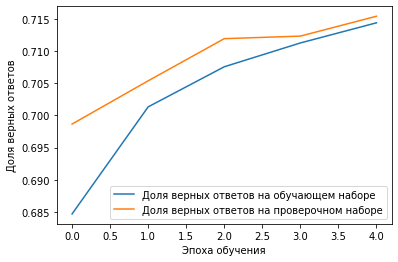

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import classification_report

prediction = model.predict([X1_test, X2_test])
print(classification_report(y_test.argmax(axis=1), prediction.argmax(axis=1), target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.69      0.77      0.73    123468
     class 1       0.74      0.66      0.70    123785

    accuracy                           0.71    247253
   macro avg       0.72      0.71      0.71    247253
weighted avg       0.72      0.71      0.71    247253



In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='cognates_second_model.png', show_shapes=True, show_layer_names=True)